In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry
from agents import run_episode

# Define environment

In [2]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=4, branching=[3,1,2], cost=1.00, scaling_factors=[1, 1, 1], seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)
    
    def reward(depth):
        if depth > 0:
            x = np.array([-2,-1,1,2])
            vals = mu + sigma * x * scaling_factors[depth-1]
            return Categorical(vals).apply(round)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

In [3]:
from toolz import compose
h = compose(hash, str)

def hash_312(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + 
        h(s[2] +
          h(s[3]) +
          h(s[4]))
      ) +
      h(s[5] + 
        h(s[6] +
          h(s[7]) +
          h(s[8]))
      ) + 
      h(s[9] + 
        h(s[10] +
          h(s[11]) +
          h(s[12]))
      )
    )

from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_312)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)

In [72]:
from exact import solve
env_decreasing = make_env2(mu=0, sigma=4, branching=[3,1,2], cost=1.00, 
                           scaling_factors=[6, 1, 1/2], ground_truth=False)

optimal_policy_decreasing = get_optimal_policy(env_decreasing)

30.139556884765625


# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

# Alternative models

## Satisficing and pruning

In [125]:
from functools import wraps

def observed(state, node):
    return not hasattr(state[node], 'sample')

@curry
def satisfruning(preference, prune=None, satisfice=None, direction=None, env=env):
    @wraps(preference)
    def new_pref(state, action, prune=prune, satisfice=satisfice, direction=direction):
        if action == env.term_action:
            if satisfice is not None:
                satisfied = env.expected_term_reward(state) >= satisfice
                return 1e10 if satisfied else -1e10
        elif prune is not None:
            if env.node_quality(action, state).expectation() <= prune:
                return -1e20
            previous_nodes = env.path_to(action)[:-1]
        if direction == 'forward':
            previous_node = env.path_to(action)[-2]  # [-1] is the clicked node
            if not observed(state, previous_node):
                return -1e10
        elif direction == 'backward':
            children = env.tree[action]
            if children and not any(observed(state, node) for node in children):
                return -1e10
        return preference(state, action)
    
    return new_pref

## Preferences

In [127]:
@satisfruning(direction='forward')
def depth_first(state, action):
    previous_nodes = env.path_to(action)[:-1]
    return len(previous_nodes)

In [128]:
@satisfruning(direction='forward')
def breadth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are closer to the start
    return -len(previous_nodes)

In [129]:
@satisfruning(direction='forward')
def best_first(state, action):
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

In [113]:
def progressive_deepening(state, action,  last_click=None):
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    if last_click:
        # version if last_click is available
        if last_clicka in env.leaves():
            if len(previous_nodes) == 1:
                # the start of a new path = another leaf on the previous path
                return len(env.path_to(last_click)[:-1])
            return len(previous_nodes)
        if last_click == previous_nodes[-1]:
            return 1e10
        return len(previous_nodes)
    else:
        # the following only works for a 3-1-2 environment
        if action in env.leaves():
            leaf_group = None
            for subtree in env.tree:
                if (len(subtree) == 2) and (action in subtree):
                    leaf_group = subtree
            for leaf in leaf_group:
                if observed(state, leaf):
                    return 1 # set same value as the beginning of a new path
        return len(previous_nodes)

# Model human data

## Load and preprocess

In [80]:
from analysis_utils import *
VERSION = 'c2.1'
exp_data = get_data(VERSION, '../experiment/data')

pdf = exp_data['participants']
pdf = pdf.loc[pdf.completed].set_index('pid', drop=False)
if 'variance' not in pdf:
    pdf['variance'] = 'constant'

print(f'{len(pdf)} participants')
complete = list(pdf.index)

def extract(q):
    return list(map(int, q['click']['state']['target']))

mdf = exp_data['mouselab-mdp'].query('pid == @complete').copy()
mdf = mdf.set_index('pid', drop=False)
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['thinking'] = mdf['rt'].apply(get(0, default=0))
mdf['variance'] = pdf['variance']

tdf = mdf.query('block == "test"').copy()
tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

# pdf['total_time'] = exp_data['survey'].time_elapsed / 60000

pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.mean()
pdf['thinking'] = mdf.groupby('pid').thinking.mean()

69 participants


/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 'pid' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 'pid' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 'pid' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


In [83]:
import json
def excluded_pids():
    sdf = exp_data['survey-multi-choice'].query('pid == @complete').set_index('pid')
    responses = pd.DataFrame(list(sdf.responses), index=sdf.index)
    grp = responses.groupby(lambda pid: pdf.variance[pid])
    correct = grp.apply(lambda x: x.mode().iloc[0])
    errors = correct.loc[pdf.variance].set_index(pdf.index) != responses
    fail_quiz = errors.sum(1) > 1

    no_click = mdf.query('block == "train_inspector"').groupby('pid').n_clicks.sum() == 0
    return fail_quiz | no_click

excluded = excluded_pids()
tdf = tdf.loc[~excluded]
print(f'excluding {excluded.sum()} out of {len(excluded)} partipicants')

excluding 16 out of 69 partipicants


/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 'pid' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.


In [88]:
def get_env(state_rewards):
    state_rewards[0] = 0
    return make_env(ground_truth=state_rewards)
tdf['env'] = tdf.state_rewards.apply(get_env)

# assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = row.env
        env.reset()
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_index': row.trial_index, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)


data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


6155 observations)


,action,pid,state,trial_id,trial_index
0,5,0,"(0, ((-8, 0.25), (-4, 0.25), (4, 0.25), (8, 0....",2045193736832319488,0
1,9,0,"(0, ((-8, 0.25), (-4, 0.25), (4, 0.25), (8, 0....",2045193736832319488,0
2,6,0,"(0, ((-8, 0.25), (-4, 0.25), (4, 0.25), (8, 0....",2045193736832319488,0
3,10,0,"(0, ((-8, 0.25), (-4, 0.25), (4, 0.25), (8, 0....",2045193736832319488,0
4,13,0,"(0, ((-8, 0.25), (-4, 0.25), (4, 0.25), (8, 0....",2045193736832319488,0


## Likelihood model

In [109]:
class MouselabModel():
    """Computes likelihoods for a softmax policy on a grid of temp and p_error."""
    def __init__(self, env, preference, data):
        self.env = env
        self.policy = SoftmaxPolicy(preference)
        self.data = data
        run_episode(self.policy, self.env)
        self.prefs = np.stack(self.data.state.apply(self.policy.preferences))
        self.prefs -= self.prefs.max(1).reshape(-1, 1)  # prevent float overflow 

        idx = np.arange(len(data))
        self.chosen = (idx, data.action.as_matrix())

    def likelihood(self, temp=1e-9, p_error=None):
        """Returns likelihood for all combinations of temp and p_error given.
        
        Return value has shape (len(self.data), len(temp), len(p_error)).
        """
        temp = np.atleast_1d(temp)
        ep = np.exp(np.einsum('ij,k -> ijk', self.prefs, 1/temp))
        probs = ep[self.chosen] / ep.sum(1)  # shape: (state, temp)
        if p_error is not None:
            p_error = np.atleast_1d(p_error)
            probs = (probs[..., np.newaxis] * (1-p_error) + 
                     self.random_likelihood[..., np.newaxis] * p_error)
        return probs

    @property
    @memoize
    def random_likelihood(self):
        return MouselabModel(self.env, lambda *_: 0, self.data).likelihood()

## Parameters to search over

In [162]:
path_values = range(-30, 31, 5)
defaults = {
    'p_error': np.linspace(0.01,0.25, 25),
    'satisfice': [v for v in path_values if v > 0],
    'prune': [v for v in path_values if v < 0],
    'temp': np.logspace(-5,1, 50),
}
models = {
#     'depth_first': {
#         **defaults,
#         'pref': depth_first,  
#         'temp': [1e-10]
#     },
#     'breadth_first': {
#         **defaults,
#         'pref': breadth_first,
#         'temp': [1e-10]
#    },
#     'progressive_deepening': {
#         **defaults,
#         'pref': progressive_deepening,
#         'temp': [1e-10]
#     },
    'best_first': {
        **defaults,
        'pref': best_first,
        'direction': ['forward', 'backward', None],
    },
    'optimal': {
        **defaults,
        'pref': optimal_policy_increasing.preference,
        'satisfice': [None],
        'prune': [None],
    },
#     'satisfruning_optimal': {
#         **defaults,
#         'pref': Q,
#     },
    'random': {
        **defaults,
        'pref': lambda s, a: 0,
        'prune': [None],
        'satisfice': [None],
        'p_error': [1],
        'temp': [1e-10]
    },
}

In [164]:
optimal = {
    'decreasing': optimal_policy_decreasing,
    'increasing': optimal_policy_increasing
}

## Find MLE

In [165]:
from utils import dict_product

def best_logp(df, n=1, group=None):
    if group:
        return df.groupby(group).apply(lambda d: d.nlargest(n, 'logp')).reset_index(drop=True)
    else: 
        return df.nlargest(n, 'logp')

def maximum_likelihood(data, pref, temp, p_error, **params):
    choices = []
    for prm in dict_product(params):
        new_pref = satisfruning(pref, **prm)
        model = MouselabModel(env, new_pref, data)
        logp = np.log(model.likelihood(temp=temp, p_error=p_error))
        total_logp = logp.sum(0)  # sum logp for each state/action

        idx = pd.MultiIndex.from_product([temp, p_error], names=['temp', 'p_error'])
        grid = pd.Series(total_logp.flat, index=idx, name='logp').reset_index()
        for k, v in prm.items():
            grid[k] = v
        choices.append(best_logp(grid, 1))

    df = best_logp(pd.concat(choices), 1)
    return df

## MLE for full dataset

In [167]:
def fit_models(data):
    for name, params in models.items():
        print(name)
        mle = maximum_likelihood(data, **params)
        mle['model'] = name
        yield mle

agg_results = pd.concat(fit_models(data.query('variance == "increasing"')))

best_first
<function best_first at 0x126af37b8> {'satisfice': [5, 10, 15, 20, 25, 30], 'prune': [-30, -25, -20, -15, -10, -5], 'direction': ['forward', 'backward', None]}


/usr/local/lib/miniconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:274: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


optimal
<function memoize.<locals>.memof at 0x112ab5510> {'satisfice': [None], 'prune': [None]}


KeyboardInterrupt: 

In [44]:
def num_params(params):
    return sum(len(choices) > 1 if hasattr(choices, '__len__') else 0 
               for choices in params.values())

k = pd.Series({model: num_params(params) for model, params in models.items()})
log_mle = agg_results.groupby('model').logp.sum()

comp = pd.DataFrame({
    'bic': np.log(len(data)) * k - 2 * log_mle,
    'aic': 2 * k - 2 * log_mle,
    'perplexity': np.exp(-agg_results.groupby('model').logp.sum() / len(data)),
    'k': k,
    'logp': log_mle.astype(int)
})
comp.bic = comp.bic.astype(int)
comp.aic = comp.aic.astype(int)
comp.perplexity = comp.perplexity.round(2)
comp.sort_values('bic')

,aic,bic,k,logp,perplexity
model,,,,,
optimal,30611,30625,2,-15303,7.48
best_first,31716,31744,4,-15854,8.04
satisfruning_optimal,32559,32587,4,-16275,8.50
breadth_first,34058,34078,3,-17026,9.38
random,34579,34579,0,-17289,9.71
satisfruning_random,34667,34688,3,-17330,9.76
progressive_deepening,34704,34725,3,-17349,9.79
depth_first,34711,34732,3,-17352,9.79


In [52]:
(comp[['bic', 'logp']]
 .sort_values('bic')
 .rename(columns={'bic': 'BIC', 'logp': 'Log Likelihood', 'k': 'Parameters'})
 .to_latex('../../paper/tables/exp1_agg_comp.tex'))

## MLE parameters for each model and each participant

In [140]:
from tqdm import tqdm
def fit_participants(data):
    def pid_mle():
        for pid, pid_data in tqdm(data.groupby('pid')):
            for name, params in {**models, 'optimal': optimal[pdf.variance[pid]]}.items():
                mle = maximum_likelihood(pid_data, **params)
                mle['pid'] = pid
                mle['model'] = name
                yield mle
    return pd.concat(pid_mle()).reset_index(drop=True)

results = fit_participants(data)


  0%|          | 0/53 [00:00<?, ?it/s]


<function best_first at 0x126af37b8> {'satisfice': [5, 10, 15, 20, 25, 30], 'prune': [-30, -25, -20, -15, -10, -5], 'direction': ['forward', 'backward', None], 'forward': ['True', 'False']}


TypeError: satisfruning() got an unexpected keyword argument 'forward'

# Analyze results

In [16]:
n_pid = len(results.pid.unique())
k = n_pid * pd.Series({model: num_params(params) for model, params in models.items()})
log_mle = results.groupby('model').logp.sum()

comp = pd.DataFrame({
    'bic': np.log(len(data)) * k - 2 * log_mle,
    'aic': 2 * k - 2 * log_mle,
    'perplexity': np.exp(-results.groupby('model').logp.sum() / len(data))
})
comp.bic = comp.bic.astype(int)
comp.aic = comp.aic.astype(int)
comp.perplexity = comp.perplexity.round(2)
comp[['bic', 'aic', 'logp']].sort_values('bic')

,bic,aic,perplexity
model,,,
best_first,29322,27907,6.10
optimal,29808,29100,6.68
satisfruning_optimal,30223,28808,6.47
depth_first,32158,31097,7.57
progressive_deepening,32362,31301,7.67
breadth_first,32436,31375,7.71
satisfruning_random,33192,32131,8.10
random,34579,34579,9.71


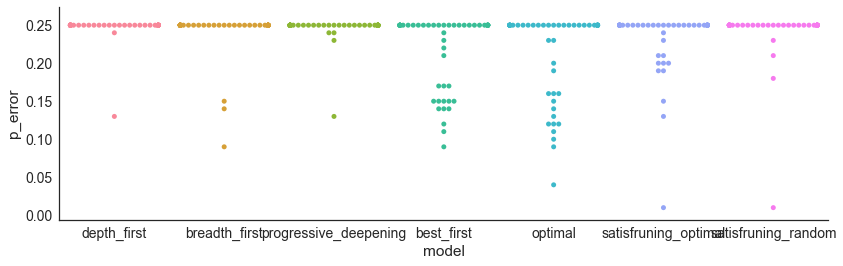

In [17]:
sns.factorplot('model', 'p_error', data=results.query('model != "random"'), 
               kind='swarm', aspect=3)

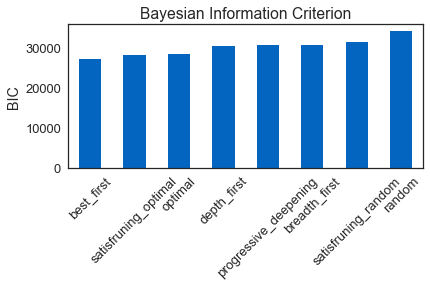

In [378]:
bic.sort_values().plot.bar(color='#0365C0')
for label in plt.gca().get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.title('Bayesian Information Criterion')
plt.ylabel('BIC')
plt.savefig('bic.pdf')

In [352]:
n = data.pid.value_counts(sort=False).sort_index()
pid_mle = best_logp(results, group='pid').set_index('pid')
(np.log(n) * k.loc[list(pid_mle.model)].as_matrix()) - 2 * pid_mle.logp
# (2 * pid_mle.logp).index

1     503.721956
2     559.984335
3     839.688411
5     610.767707
6     187.608323
7     617.510013
9     217.808443
10    567.035451
11    653.593363
12    153.896961
13    471.376800
14    560.463025
15    637.003477
16    952.693569
17    176.821068
18    221.030934
19    470.219852
21    258.916269
23    234.036440
24    511.411140
25    740.897252
26    494.937970
27    246.744259
28    498.620895
29    188.723368
30    580.950138
32    500.741708
33    621.991796
34    616.644857
35    375.353656
36    195.083662
38    183.715841
39    492.805581
41    468.508073
44    578.133203
45    545.764745
46    888.430819
47    294.070354
48    513.255793
49    214.958740
50    645.679940
51    526.650598
52    617.985776
53    443.022596
54    431.707589
55    586.862157
56    596.561454
57    454.386257
59    583.163484
60    486.933388
dtype: float64

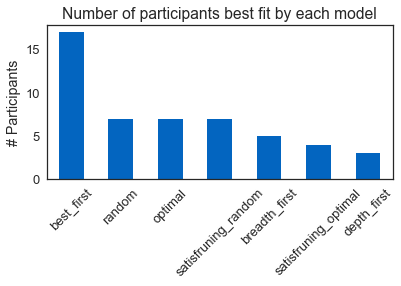

In [379]:
best_logp(results, group='pid').model.value_counts().plot.bar(color='#0365C0')
plt.ylabel('# Participants')
for label in plt.gca().get_xticklabels():
    label.set_rotation(45)
plt.tight_layout()
plt.title('Number of participants best fit by each model')
plt.savefig('pid_count.pdf')

In [263]:
results.satisfice = results.satisfice.astype(float)
results.prune = results.prune.astype(float)

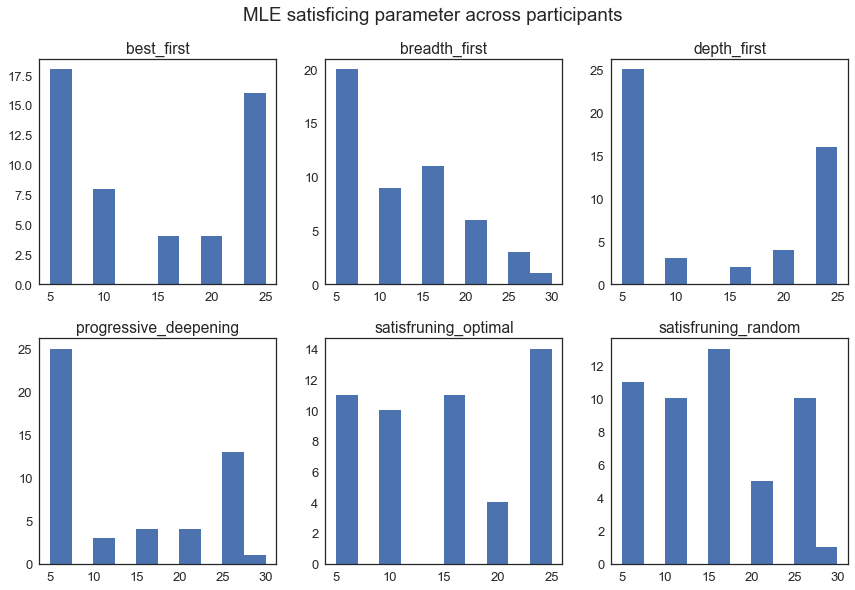

In [264]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = iter(axes.flat)
for p, dd in results.dropna().groupby('model'):
    ax = next(axes)
    dd.satisfice.plot.hist(ax=ax)
    ax.set_ylabel('')
    ax.set_title(p)
    
plt.tight_layout()
plt.suptitle('MLE satisficing parameter across participants', y=1.03)

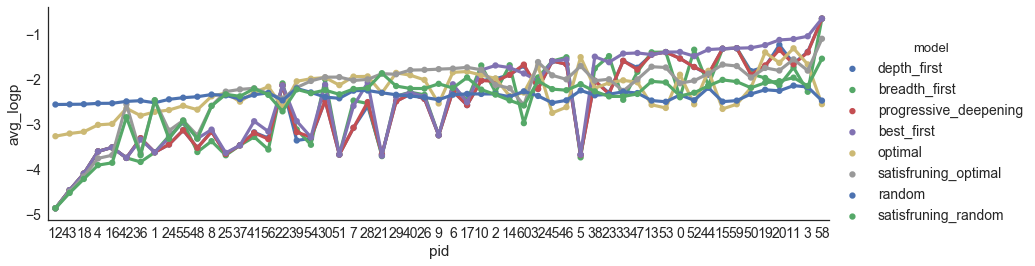

In [211]:
results['avg_logp'] = results.logp / list(data.pid.value_counts()[results.pid])
pal = sns.color_palette()
pal[-1] = '#999999'

order = list(results.groupby('pid').avg_logp.max().sort_values().index)
sns.factorplot('pid', 'avg_logp', hue='model', 
               data=results,
               aspect=3, order=order, palette=pal, markers='.')

In [391]:
mledf = best_logp(results, group='pid').set_index('pid')
mledf['high_score'] = (pdf.score > pdf.score.median())
os.makedirs(f'results/{VERSION}/', exist_ok=True)
mledf.to_csv(f'results/{VERSION}/mle.csv')

In [599]:
mledf

,temp,p_error,logp,satisfice,prune,model,high_score
pid,,,,,,,
1,5.689866e+00,0.15,-241.147806,25.0,-10.0,best_first,False
2,3.237458e+00,0.24,-269.466787,25.0,-15.0,best_first,True
3,1.000000e-10,0.25,-411.687087,15.0,-15.0,breadth_first,True
5,7.543120e+00,0.11,-294.301327,25.0,-30.0,best_first,False
6,1.000000e-10,1.00,-93.804161,NaN,NaN,random,True
7,1.000000e-10,0.25,-301.386024,10.0,-10.0,satisfruning_random,False
9,1.000000e-10,1.00,-108.904222,NaN,NaN,random,False
10,1.000000e-10,0.25,-276.094586,10.0,-5.0,satisfruning_random,False
11,1.930698e-01,0.12,-321.587195,NaN,NaN,optimal,False


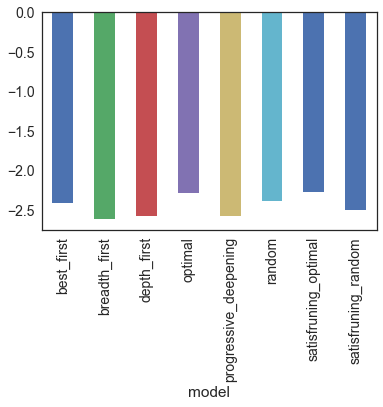

In [213]:
results.groupby('model').avg_logp.mean().plot.bar()

# Qualitative

In [393]:
env.init
env.all_paths()

[[0, 1, 2, 3],
 [0, 1, 2, 4],
 [0, 5, 6, 7],
 [0, 5, 6, 8],
 [0, 9, 10, 11],
 [0, 9, 10, 12]]

# Other stuff

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [434]:
(53* 30)

1590

In [427]:
print('6 choices', np.random.randint(-2, 3, size=(6, 10000)).max(0).mean())
print('4 choices', np.random.randint(-2, 3, size=(3, 10000)).max(0).mean())


6 choices 1.6839
4 choices 1.2067


In [397]:
from evaluation import get_util
u = get_util(optimal_policy, [env] * 500, return_mean=False)
print(u.mean(), u.std())

8.126 9.348203132346194


In [ ]:
from agents import run_episode
def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

In [ ]:
np.random.seed(1)

import json
def demo(env):
    trace = run_episode(optimal_policy, env)
    
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
        'demo': 
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]
env_type = ''.join(map(str, branch))
envs = [make_env(mu=0, sigma=6, quantization=4, branching=branch)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

In [ ]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)